# Fibers | Comparison between TCAM and Gemelli

## Setup
Let’s begin by importing the modules we’ll need.

In [12]:
import sys
sys.path.append('/home/labs/elinav/uria/mprod_package/')

import pandas as pd
import numpy as np

from mprod.dimensionality_reduction import TCAM
from mprod import table2tensor
import random
import scipy
from multiprocessing import Pool
from sklearn.metrics import pairwise_distances
from itertools import combinations
import re
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')
%matplotlib inline



## Dataset

The second study <a id="1">[1]</a> is a common interventional experiment, testing the effect of different resistant starch4 (RS4) structures on the microbiome composition, where stool samples were collected each week during a five weeks long trial (n=40). The four arms in this experiment were defined by the source of fibers: tapioca and maize groups represent sources of fermentable fibers, while potato and corn groups mostly contain fibers that are inaccessible for microbiome degradation thus considered control groups.

Once pandas is loaded, we can read the dataset

In [2]:
file_path = "./Deehan2020.tsv"
data_raw = pd.read_csv(file_path, index_col=[0,1], sep="\t"
                       , dtype={'Week':int})

meta_path = "./metadata_Deehan2020.tsv"
meta = pd.read_csv(meta_path, index_col=[0], sep="\t")

display(data_raw.head())
display(meta.head())


k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter;s__  \
Participant Week                                                                                                                          
F03         0                                              0.087592                                                                       
            1                                              0.087563                                                                       
            2                                              0.087970                                                                       
            3                                              0.087014                                                                       
            4                                              0.087429                                                                       

                  k__Bacteria;__;__;__;__;__;__  \
Participant Week                                  
F03         0                          0.170869   
            1                          0.298388   
            2                          0.096154   
            3                          0.434102   
            4                          0.235990   

                  k__Bacteria;p__Actinobacteria;c__Actinobacteria;__;__;__;__  \
Participant Week                                                                
F03         0                                              0.087592             
            1                                              0.087563             
            2                                              0.087970             
            3                                              0.087014             
            4                                              0.087429             

                  k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__  \
Participant Week                                                                                                              
F03         0                                              0.090460                                                           
            1                                              0.087563                                                           
            2                                              0.087970                                                           
            3                                              0.087014                                                           
            4                                              0.087429                                                           

                  k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Corynebacteriaceae;g__Corynebacterium;__  \
Participant Week                                                                                                                   
F03         0                                              0.087592                                                                
            1                                              0.087563                                                                
            2                                              0.087970                                                                
            3                                              0.087014                                                                
            4                                              0.087429                                                                

                  k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Corynebacteriaceae;g__Corynebacterium;s__  \
Participant Week                                                                                                                    
F03         0                        

,Group
Participant,
M37,Control
M38,Control
F05,Control
F17,Control
F18,Control


## TCAM

## Preprocessing and baseline normalization

Since microbiome data tends to cluster by participant, meaning that variation coming from interindividual differences tend overshadow any other source of variation, including temporal trends, the task of identifying mutual temporal trajectories in microbiome composition is very challenging.

Keeping in mind that we are only concerned with the direction of temporal variation trends (rather than the concrete baseline), one simple way of tackling this challenge would be to look at deviations from the baseline period.

That is, instead of looking at raw values $x_{ij}$ (the $j^{th}$ time point of subject $i$), we consider tthe followoing:


$$
z_{ij} = \log_{2}(x_{ij} / \mu(x_{i}) )
$$


where $\mu(x_{i}) $ denotes the mean of baseline measurements of subject $i$

Using pandas, this transfromation looks like:

In [3]:
data_normalized = data_raw.groupby(level = 'Participant')\
                    .apply(lambda x:np.log2( x/x.query("Week == 0").mean() )) 

display(data_normalized.head())

k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter;s__  \
Participant Week                                                                                                                          
F03         0                                              0.000000                                                                       
            1                                             -0.000481                                                                       
            2                                              0.006209                                                                       
            3                                             -0.009551                                                                       
            4                                             -0.002683                                                                       

                  k__Bacteria;__;__;__;__;__;__  \
Participant Week                                  
F03         0                          0.000000   
            1                          0.804302   
            2                         -0.829463   
            3                          1.345145   
            4                          0.465834   

                  k__Bacteria;p__Actinobacteria;c__Actinobacteria;__;__;__;__  \
Participant Week                                                                
F03         0                                              0.000000             
            1                                             -0.000481             
            2                                              0.006209             
            3                                             -0.009551             
            4                                             -0.002683             

                  k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__  \
Participant Week                                                                                                              
F03         0                                              0.000000                                                           
            1                                             -0.046960                                                           
            2                                             -0.040271                                                           
            3                                             -0.056030                                                           
            4                                             -0.049163                                                           

                  k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Corynebacteriaceae;g__Corynebacterium;__  \
Participant Week                                                                                                                   
F03         0                                              0.000000                                                                
            1                                             -0.000481                                                                
            2                                              0.006209                                                                
            3                                             -0.009551                                                                
            4                                             -0.002683                                                                

                  k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Corynebacteriaceae;g__Corynebacterium;s__  \
Participant Week                                                                                                                    
F03         0                        

### TCAM analysis

Before we can apply the TCAM, we must cast our dataset, that is currently in the form of a long matrix, to a tensor structure.
While doing so, we must make sure to maintain the information regarding indices for subjects, features (taxa annotations) and timepoints.

We implemented a few utility functions in our code to assist with this task:

In [4]:
tensor_data, mode1_map, mode3_map = table2tensor(data_normalized)
mode1_reverse_map = {val:k for k,val in mode1_map.items()}

display(tensor_data.shape)
print(mode1_map)
print(mode1_reverse_map)

(34, 210, 5)

{'F03': 0, 'F04': 1, 'F05': 2, 'F10': 3, 'F11': 4, 'F12': 5, 'F13': 6, 'F14': 7, 'F15': 8, 'F16': 9, 'F17': 10, 'F18': 11, 'F20': 12, 'F21': 13, 'F22': 14, 'M22': 15, 'M23': 16, 'M24': 17, 'M25': 18, 'M26': 19, 'M27': 20, 'M28': 21, 'M29': 22, 'M30': 23, 'M31': 24, 'M32': 25, 'M33': 26, 'M34': 27, 'M36': 28, 'M37': 29, 'M38': 30, 'M39': 31, 'M40': 32, 'M41': 33}
{0: 'F03', 1: 'F04', 2: 'F05', 3: 'F10', 4: 'F11', 5: 'F12', 6: 'F13', 7: 'F14', 8: 'F15', 9: 'F16', 10: 'F17', 11: 'F18', 12: 'F20', 13: 'F21', 14: 'F22', 15: 'M22', 16: 'M23', 17: 'M24', 18: 'M25', 19: 'M26', 20: 'M27', 21: 'M28', 22: 'M29', 23: 'M30', 24: 'M31', 25: 'M32', 26: 'M33', 27: 'M34', 28: 'M36', 29: 'M37', 30: 'M38', 31: 'M39', 32: 'M40', 33: 'M41'}


## The TCAM object

Due to cenceptual similarity with matrix transformations such as PCA, we chose to implement the TCAM using the `sklearn.base.TransformerMixin` class (see [scikit-learn's documentation](https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html) ).

This enables familiar interface when working with TCAM inside Python's ML echosystem.
Once the `TCAM` class is instantiated, we can fit it to our data, and apply the resulting transform exactly as we would with any other object implementing subclass of `sklean.base.TransformerMixin`



**Note**\: By using the default `TCAM` parameters. We set the tensor-matrix multiplication (defined by the linear $n \to n$ mapping $\bf{M}$, needed for the tensor-tensor product construction) as the discrete cosine transform.
By setting the `fun_m` and `inv_m` parameters, it is possible (and desired) to modify the default transformation (see the package documentation)


In [5]:
tcam = TCAM(n_components=None)    # will produce minimal number of components such that
                                # total explained var > 99%

transformed_data = tcam.fit_transform(tensor_data)

A scatter plot of the TCAM scores 

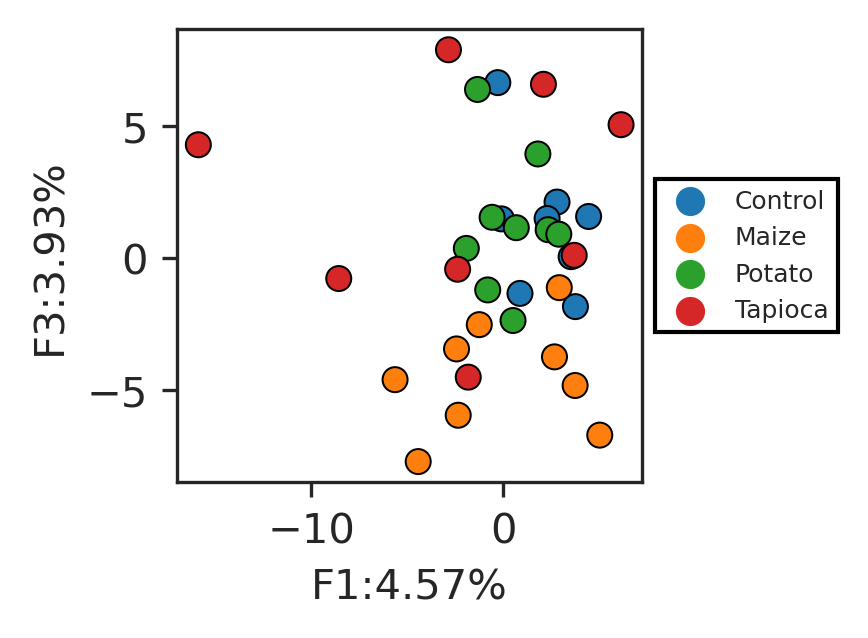

In [6]:
df_tca = pd.DataFrame(transformed_data).rename(index = mode1_reverse_map)

rounded_expvar = np.round(100*tcam.explained_variance_ratio_, 2)

df_tca.columns = [f'F{i}:{val}%' for i,val in enumerate(rounded_expvar, start = 1)]

loadings = tcam.mode2_loadings
df_loadings = pd.DataFrame(loadings, index =  data_normalized.iloc[:,0:].columns)
df_loadings.columns = [f'F{i}:{val}%' for i,val in enumerate(rounded_expvar, start = 1)]

df_plot = meta.merge(df_tca, left_on = 'Participant', right_index=True)
f1 = df_tca.columns[0]
f2 = df_tca.columns[2]

fig, ax = plt.subplots(figsize = [2,2], dpi = 300)

sns.scatterplot(data = df_plot, x = f1, y = f2 , hue='Group', ax = ax, edgecolor = 'k', linewidths=.1)

ax.legend(loc='center left', fontsize = 6, fancybox = False, framealpha = 1, edgecolor = 'k', bbox_to_anchor=(1, 0.5))

plt.show()

### PERMANOVA functions

In [7]:

def pairwise_melt_meta(meta, data):

    _dm = pairwise_distances(data.loc[meta['SampleID']])
    for i in range(_dm.shape[0]):
        _dm[i,i:] = None
    _dm_df = pd.DataFrame(_dm, index = meta['SampleID'].rename('sample1'), columns=meta['SampleID'].rename('sample2'))

    _dm_melt = pd.melt(_dm_df.reset_index(), id_vars=['sample1'], value_name='d').dropna()

    metacols = ['rGroup','Participant', 'SampleID']
    _dm_melt2 = meta.loc[:, metacols].merge(_dm_melt, right_on = 'sample2', left_on = 'SampleID', how = 'right').drop('SampleID', axis=1)
    _dm_melt_meta = meta.loc[:, metacols].merge(_dm_melt2, right_on = 'sample1', left_on= 'SampleID', how = 'right', suffixes = ("1","2")).drop('SampleID', axis=1)
    return _dm_melt_meta

def random_combination(iterable, r):
    "Random selection from itertools.combinations(iterable, r)"
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(range(n), r))
    return tuple(pool[i] for i in indices)


def ss_total(data):
    return (data['d']**2).sum()

def ss_within(data):
    if 'rGroup11' in data.columns:
        # Group11 Group22 are the permuted labels of samples in Group1, Group2 resp'
        return data.query('rGroup11 == rGroup22').groupby('rGroup11')['d'].apply(lambda x: (x**2).sum()).sum()
    else:
        return data.query('rGroup1 == rGroup2').groupby('rGroup1')['d'].apply(lambda x: (x**2).sum()).sum()

def ss_between(data, ss_t):
    return ss_t - ss_within(data)

def Fstat(data, ss_t = None, N = None):
    # p = 2 as there are always 2 groups in our cases
    if N is None:
        N = len(set(data['sample1'].tolist() + data['sample2'].tolist()))
    if ss_t is None:
        ss_t = ss_total(data)
    ss_w = ss_within(data)
    ss_b = ss_t - ss_w
    return ss_b / (ss_w / (N - 2))


def gen_rperm(meta, r):
    _mice_map = meta.loc[:, ['Participant', 'rGroup']].copy()
    _mice_map.drop_duplicates(inplace=True)
    _mice_map.index = _mice_map['Participant']
    gsizes = _mice_map.groupby('rGroup').size()
    g1size, g1label, g2label = gsizes[0], gsizes.index[0], gsizes.index[-1]

    
    for combo in  random_combination(combinations(_mice_map.index, g1size), r):
        _mice_map['Group_perm'] = g2label
        _mice_map.loc[combo ,'Group_perm'] = g1label
        yield _mice_map['Group_perm'].to_dict()
        
import time 

def _permfs(args):
    __data, tv, N, permdict = args
    _data = __data.copy()
    _data['rGroup11'] = _data['Participant1'].map(permdict)
    _data['rGroup22'] = _data['Participant2'].map(permdict)
    fstat = Fstat(_data, tv, N)
    return fstat


def run_permanova(meta, data, nperms = 1000):
    _dmm = pairwise_melt_meta(meta, data)

    _dmm['rGroup11'] = _dmm['rGroup1'].copy()
    _dmm['rGroup22'] = _dmm['rGroup2'].copy()

    N = len(set(_dmm['sample1'].tolist() + _dmm['sample2'].tolist()))
    total_var = ss_total(_dmm)
    fs_obs = Fstat(_dmm, total_var, N)

    
    with Pool(processes=5) as p:
        fs_perms = p.imap(_permfs, ((_dmm, total_var, N, dd) for dd in gen_rperm(meta, nperms)))
        
        fs_perms = np.array([x for x in fs_perms])

    return ((fs_perms > fs_obs).sum() ) / (nperms )     

### PERMANOVA analysis

In [8]:
meta_perm = pd.read_csv(meta_path, sep="\t")
meta_perm['SampleID'] = meta_perm['Participant']
n_factors = (np.cumsum(tcam.explained_variance_ratio_) < .2).sum() + 1 # 20% variance
perm_res = pd.DataFrame(columns=['g1','g2','p'])


for g1,g2, in combinations(meta_perm['Group'].unique(),2):
    meta_comp = meta_perm.loc[meta_perm['Group'].isin([g1,g2])].copy()
    meta_comp.rename(columns = {'Group':'rGroup'},inplace = True)
    table_comp = df_tca.loc[meta_comp['SampleID']].copy()
    
    n_all = meta_comp.loc[meta_comp['rGroup'].isin([g1,g2])].shape[0]
    n_1 = meta_comp.loc[meta_comp['rGroup'].isin([g1])].shape[0]
    n_2 = meta_comp.loc[meta_comp['rGroup'].isin([g2])].shape[0]
    n_perm = 1000
    
    p = run_permanova(meta_comp, df_tca.loc[meta_comp['SampleID']].iloc[:,:n_factors].copy(), nperms = n_perm)
    perm_res.loc[perm_res.shape[0],:] = [g1,g2,p]
perm_res

,g1,g2,p
0,Control,Maize,0.019
1,Control,Potato,0.347
2,Control,Tapioca,0.457
3,Maize,Potato,0.005
4,Maize,Tapioca,0.012
5,Potato,Tapioca,0.2


Barplot with top and bottom 2.5% loadings for F3

/home/labs/elinav/uria/.conda/envs/mprod/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


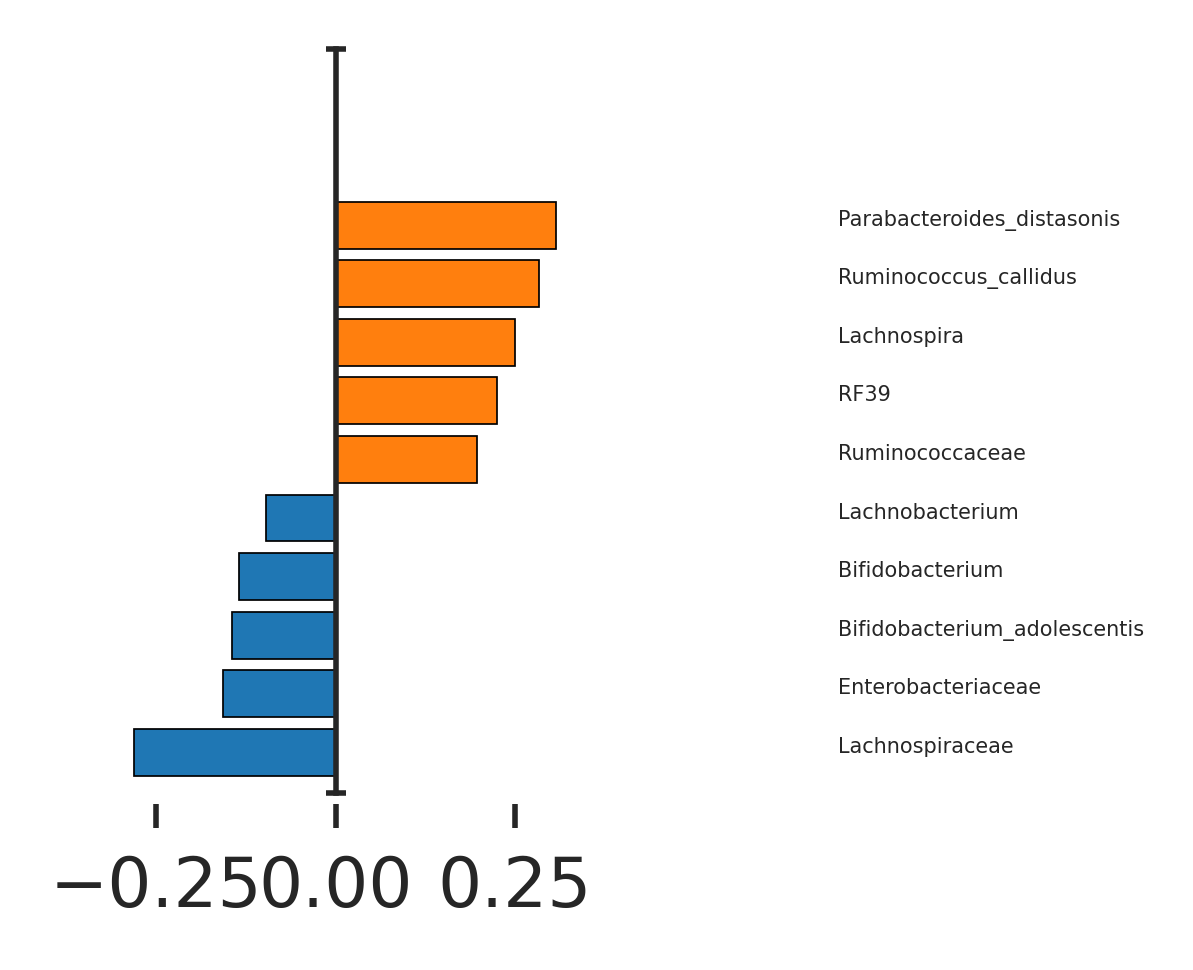

In [9]:
loadings_f3 = df_loadings.iloc[:,2].sort_values().copy()
top_bottom = [ loadings_f3.nlargest(5), loadings_f3.nsmallest(5) ]
loadings_f3 = pd.concat(top_bottom)
loadings_f3 = loadings_f3.sort_values()
loadings_f3 = loadings_f3.rename('F3')
loadings_f3 = loadings_f3.reset_index()

fig,ax  = plt.subplots(1,1, figsize=[1.2,2], dpi = 500)
ax.barh(y = loadings_f3.query('F3 < 0').index, width = loadings_f3.query('F3 < 0')['F3'] 
       , linewidth = .25, edgecolor = 'k')
ax.barh(y = loadings_f3.query('F3 > 0').index.astype(int), width = loadings_f3.query('F3 > 0')['F3']
        , linewidth = .25, edgecolor = 'k')


ax.set_yticks([-.7,loadings_f3.index.max() + 3])
ax.set_yticklabels([])

loadings_f3.index.names
for i, row in loadings_f3.iterrows():
    sname = str(row['index'])
    sname = sname.replace(";__", "")
    sname = sname.replace(";s__", "_")
    sname = re.sub(";s__$", "", sname)
    sname = re.sub('\w__[;]*','', sname)
    sname = re.sub("[;_]*$","",  sname)
    sname = sname.split(";")[-1]
    ax.text(x=0.7, y=i, s = sname, fontdict={'size':3})
        
    
ax.yaxis.set_tick_params(size = 3, length = 400,direction = 'inout')


sns.despine( top=True,bottom=True,right=True,trim=True)

ax.spines['left'].set_position('zero')
plt.tight_layout()

### Pruning stratetgy

In [10]:
def prune_factors(transformed_data, row_factors, mwt_transformer, criterion = 'n_factors', threshold = -1 ):

    assert criterion in ['n_factors', 'min_total_var','min_var','gap']
    
    
    mwt_aov = transformed_data.copy()

    mwt_aov.columns = np.arange(0,mwt_aov.columns.size)

    def apply_f(x):
        return pd.Series(scipy.stats.f_oneway(*[x.loc[v] for k,v in row_factors.items()])
                         , index = ['F', 'P(>F)'])
    
    if criterion == 'min_total_var':
        n_factors = np.argmax(mwt_transformer.explained_variance_ratio_.cumsum() > threshold) + 1
    elif criterion == 'min_var':
        n_factors = np.argmin(mwt_transformer.explained_variance_ratio_ > threshold)
    elif criterion == 'gap':
        n_factors = np.argmin((-np.diff(mwt_transformer.explained_variance_ratio_)) > threshold)
    else:
        n_factors = mwt_transformer.explained_variance_ratio_.size if threshold == -1 else threshold
    
    n_factors = max(n_factors, 1)

    fres = (mwt_aov.iloc[:,:n_factors]).apply(apply_f).T.sort_values('P(>F)')
    
    fres['q'] = multipletests(fres['P(>F)'].values, method = 'fdr_bh')[1]
    return fres.sort_values('q')

In [13]:
from statsmodels.stats.multitest import multipletests

meta_path = "./metadata_Deehan2020.tsv"
meta = pd.read_csv(meta_path, sep="\t")
loadings = df_loadings
factors = df_tca

# construct a row mapping dictionary, relating each rowname (index) in the data to the relevant factor (group)
rmapping_ = meta.groupby('Group').apply(lambda x:x['Participant'].astype(str).tolist()).to_dict()
rmapping_ = {k:[s for s in v if s in factors.index] for k,v in rmapping_.items()}

# prune the factors according to their ability to seperate the data

fres = prune_factors(factors, rmapping_, tcam, criterion='min_total_var', threshold=.5)
fres = fres.loc[fres['P(>F)'] < 0.05].index.tolist() # take features with P < 0.05

# Compute the norm for each feature with respect to the chosen (significant) factors
absval = loadings.iloc[:,fres].copy()
absval = absval.apply(np.linalg.norm, axis=1)**2

# log transform the squared norm
log_absval = np.log(absval)

# Fit a Laplace random variable based on the mean and sd/2 on the log(norm^2)
mean_logval = log_absval.mean()
sd_logval = log_absval.std()
random_var = scipy.stats.laplace(loc = mean_logval, scale=(sd_logval)/2)

# Monte Carlo estimation of the .75 quantile of the Laplace random variable 
rsample = pd.Series(random_var.rvs(10000)) # Sufficient sample
top_quar = rsample.quantile(0.9) # upper quartile estimation



# Prune all features with log(norm^2) > top_quar
ind_pruned = log_absval[log_absval>top_quar].index.to_series().reset_index(drop=True)
ind_pruned.to_csv("./Deehan2020_pruned_features.csv", index = False) # store the list of features
print(ind_pruned.size)

# After running Deehan2020_lmer.R
lmer_path = "./Deehan2020_ra.lmer.pruned.tsv"
lmer = pd.read_csv(lmer_path, sep="\t")
pruned_lmer_pvalue = lmer.loc[lmer['interaction.pvalue'] < 0.05].index.tolist()
display(len(pruned_lmer_pvalue))
pruned_lmer_padj = lmer.loc[lmer['interaction.padj'] < 0.05].index.tolist()
display(len(pruned_lmer_padj))
pruned_lmer_padj

53


14

7

['k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Porphyromonadaceae.g__Parabacteroides.s__distasonis',
 'k__Bacteria.p__Firmicutes.__.__.__.__.__',
 'k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Lachnospiraceae.g__Blautia.__',
 'k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Lachnospiraceae.g__Dorea.s__',
 'k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Lachnospiraceae.g__.Ruminococcus..s__',
 'k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Ruminococcaceae.g__Ruminococcus.s__callidus',
 'k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Enterobacteriales.f__Enterobacteriaceae.__.__']

Time series graphs describing 7 of the significant bacteria when applying tcam pruning strategy.

<function seaborn.distributions.distplot>

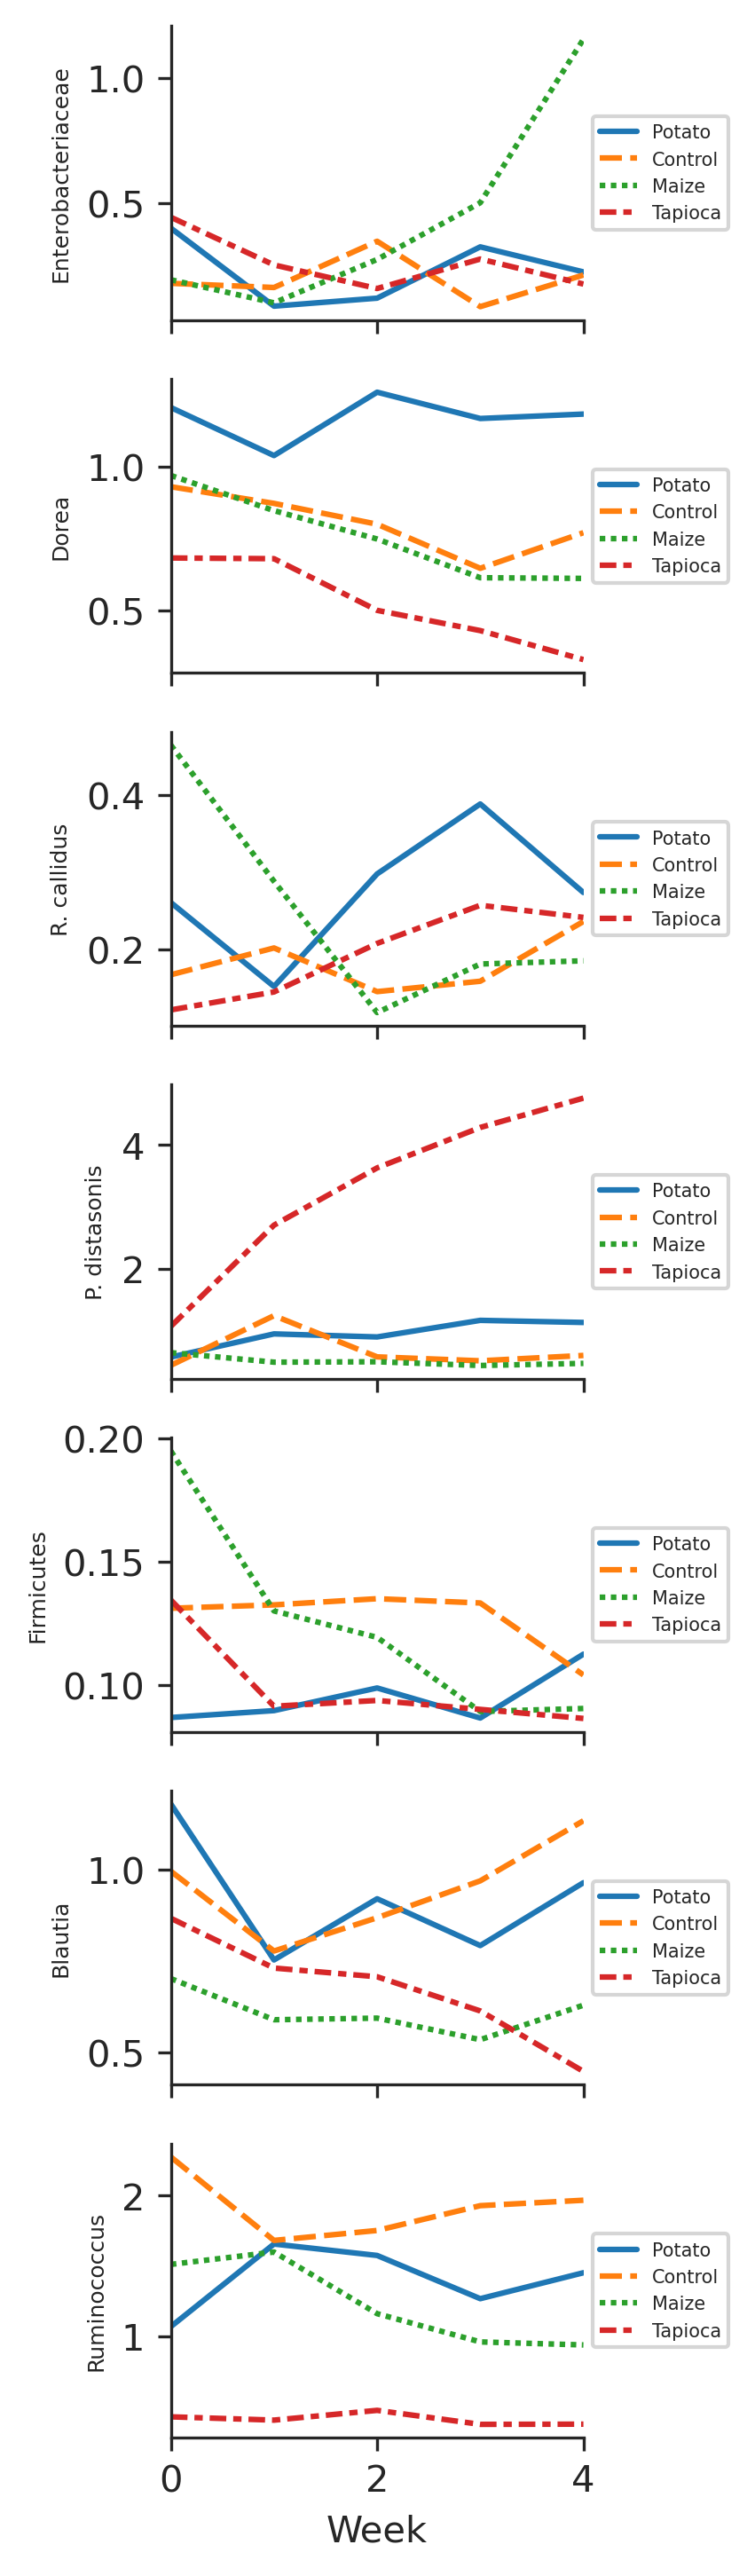

In [32]:
file_path = "./Deehan2020.tsv"
data = pd.read_csv(file_path, index_col=[0,1], sep="\t"
                       , dtype={'Week':int})
meta_path = "./metadata_Deehan2020.tsv"
metadata = pd.read_csv(meta_path, index_col=[0], sep="\t")

data2 =  metadata.join(data)
fig, axe = plt.subplots(7,1, sharex=True)
fig.set_size_inches([2,12])
fig.set_dpi(300)

ax1 = axe[0]
sns.lineplot(data = data2
             , x = 'Week', y = "k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae;__;__", ci = None
             ,hue='Group', style='Group', legend = 'full', ax = ax1)

ax2 = axe[1]
sns.lineplot(data = data2
             , x = 'Week', y = "k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Dorea;s__", ci = None
             ,hue='Group', style='Group', legend = 'full', ax = ax2)

ax3 = axe[2]
sns.lineplot(data = data2
              , x = 'Week', y = "k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus;s__callidus", estimator=np.mean, ci = None
              ,hue='Group', style='Group', legend = 'full', ax = ax3)

ax4 = axe[3] 
sns.lineplot(data = data2
              , x = 'Week', y = "k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Parabacteroides;s__distasonis", estimator=np.mean, ci = None
              , hue='Group', style='Group', legend = 'full', ax = ax4)

ax5 = axe[4] 
sns.lineplot(data = data2
              , x = 'Week', y = "k__Bacteria;p__Firmicutes;__;__;__;__;__", estimator=np.mean, ci = None
              , hue='Group', style='Group', legend = 'full', ax = ax5)

ax6 = axe[5] 
sns.lineplot(data = data2
              , x = 'Week', y = "k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia;__", estimator=np.mean, ci = None
              , hue='Group', style='Group', legend = 'full', ax = ax6)

ax7 = axe[6] 
sns.lineplot(data = data2
              , x = 'Week', y = "k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__[Ruminococcus];s__", estimator=np.mean, ci = None
              , hue='Group', style='Group', legend = 'full', ax = ax7)

ax1.set_ylabel('Enterobacteriaceae', fontsize = 6)
ax2.set_ylabel('Dorea', fontsize = 6)
ax3.set_ylabel('R. callidus', fontsize = 6)
ax4.set_ylabel('P. distasonis', fontsize = 6)
ax5.set_ylabel('Firmicutes', fontsize = 6)
ax6.set_ylabel('Blautia', fontsize = 6)
ax7.set_ylabel('Ruminococcus', fontsize = 6)

ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=5)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=5)
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=5)
ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=5)
ax5.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=5)
ax6.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=5)
ax7.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=5)

ax1.set_xlim(0, 4)
ax2.set_xlim(0, 4)
ax3.set_xlim(0, 4)
ax4.set_xlim(0, 4)
ax5.set_xlim(0, 4)
ax6.set_xlim(0, 4)
ax7.set_xlim(0, 4)

sns.despine()


Area under the Curve of top discriminant features (Factor 3)

In [15]:
from sklearn import metrics

def auc_group(df):
    y = df.Abundance
    x = df.Week
    return metrics.auc(x, y)


data_hmp = data2.filter(items=loadings_f3['index'])
data_hmp_stacked = data_hmp.stack()
data_hmp_stacked = pd.DataFrame(data_hmp_stacked)
data_hmp_stacked.columns =['Abundance']
data_hmp_stacked.reset_index(inplace=True)
data_hmp_stacked.columns =['Participant', 'Week', 'Bacteria', 'Abundance']
auc_group = data_hmp_stacked.groupby(["Participant", "Bacteria" ]).apply(auc_group)
auc_group = pd.DataFrame(auc_group)
auc_group.columns = ['AUC']
auc_group.reset_index(inplace=True)

auc_group = auc_group.pivot(index='Participant', columns='Bacteria', values='AUC')
columns_auc = auc_group.columns
new_columns_auc = []
for column in columns_auc:
    new_colum = column.replace(";__", "").replace(";s__", "_")
    new_colum = re.sub(";s__$", "", new_colum)
    new_colum = re.sub('\w__[;]*','', new_colum)
    new_colum = re.sub("[;_]*$","",  new_colum)
    new_colum = new_colum.split(";")[-1]
    new_columns_auc.append(new_colum)

auc_group.columns = new_columns_auc

meta_path = "./metadata_Deehan2020.tsv"
metadata = pd.read_csv(meta_path, sep="\t", index_col=[0])

auc_group_meta =  auc_group.join(metadata)

auc_group_meta = auc_group_meta.sort_values("Group")



Heatmap representing per-subject AUC (log scale) for F3 top and bottom 2.5% contributing bacteria

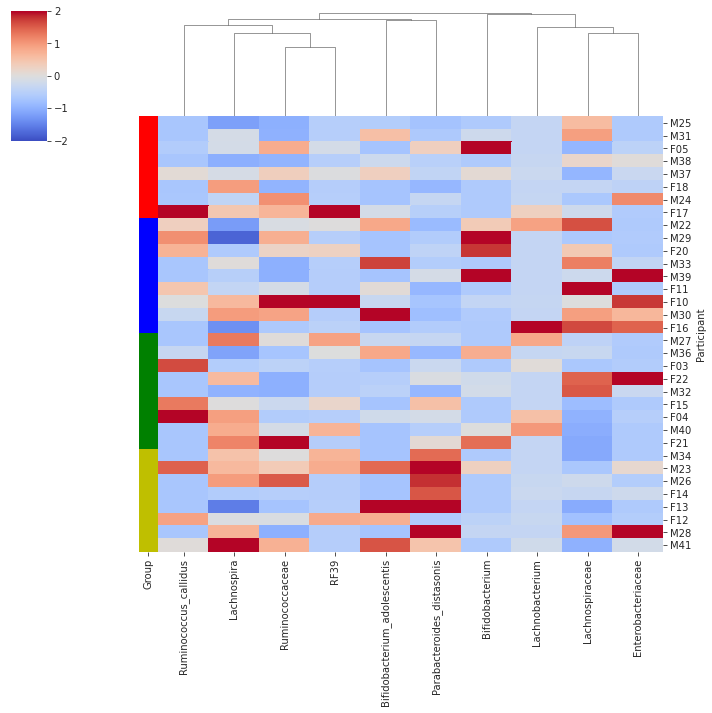

In [16]:

lut = dict(zip(auc_group_meta['Group'].unique(), "rbgy"))
row_colors = auc_group_meta['Group'].map(lut)
auc_group_meta_final = auc_group_meta.drop(['Group'], axis=1)
sns.clustermap(auc_group_meta_final,z_score=1, row_colors=row_colors, row_cluster=False,  cmap = 'coolwarm', vmin = -2, vmax = 2)


## Gemelli | Compositional Tensor Factorization

Running compositional tensor factorization to the same dataset

In [17]:
from biom import load_table
from gemelli.rpca import auto_rpca
import pandas as pd
from gemelli.ctf import ctf

# import the data table
table = load_table('./species_Deehan.biom')

# import metadata
metadata = pd.read_csv('./metadata_Deehan_gemelli.tsv', sep='\t',
                       dtype={'Sample':'str'}).set_index('Sample')



# run CTF
ctf_results = ctf(table.copy(), metadata.reindex(table.ids()),
                  'Participant',
                  'Week')

# expand the results
subject_biplot = ctf_results[0]
state_biplot = ctf_results[1]
distance_matrix = ctf_results[2]
state_subject_ordination = ctf_results[3]
state_feature_ordination = ctf_results[4]



Ordination scatter plot of the data, based on the Gemelli method <a id="2">[2]</a>

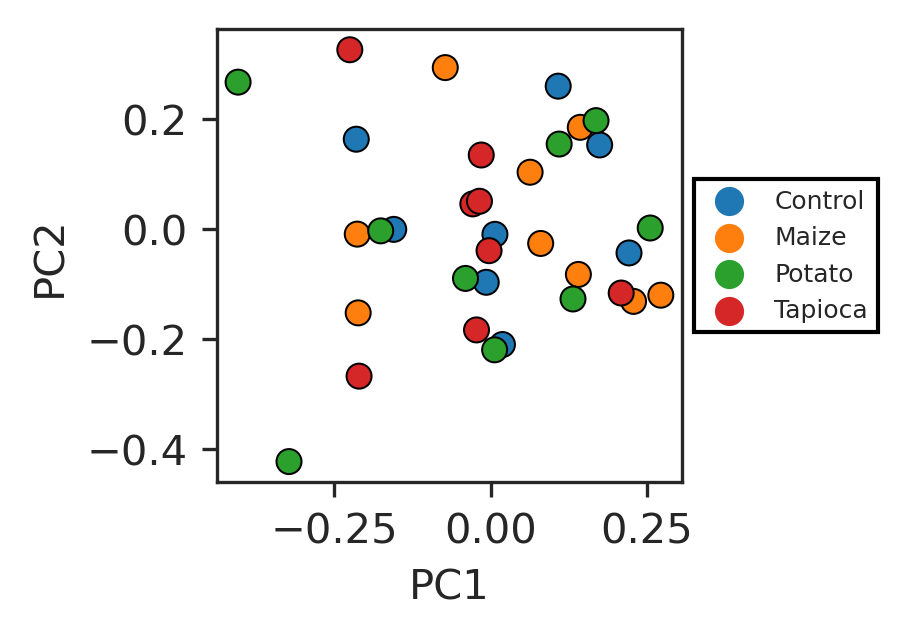

In [18]:
meta_path = "./metadata_Deehan2020.tsv"
meta = pd.read_csv(meta_path, index_col=[0], sep="\t")
df_plot = meta.merge(subject_biplot.samples, left_on = 'Participant', right_index=True)

f1 = subject_biplot.samples.columns[0]
f2 = subject_biplot.samples.columns[1]
fig, ax = plt.subplots(figsize = [2,2], dpi = 300)

sns.scatterplot(data = df_plot, x = f1, y = f2 , hue='Group', ax = ax, edgecolor = 'k', linewidths=.1)

ax.legend(loc='center left', fontsize = 6, fancybox = False, framealpha = 1, edgecolor = 'k', bbox_to_anchor=(1, 0.5))

plt.show()

### PERMANOVA analysis

In [ ]:
meta_perm = pd.read_csv(meta_path, sep="\t")
meta_perm['SampleID'] = meta_perm['Participant']
n_factors = 4
perm_res = pd.DataFrame(columns=['g1','g2','p'])


for g1,g2, in combinations(meta_perm['Group'].unique(),2):
    meta_comp = meta_perm.loc[meta_perm['Group'].isin([g1,g2])].copy()
    meta_comp.rename(columns = {'Group':'rGroup'},inplace = True)
    table_comp = subject_biplot.samples.loc[meta_comp['SampleID']].copy()

    n_all = meta_comp.loc[meta_comp['rGroup'].isin([g1,g2])].shape[0]
    n_1 = meta_comp.loc[meta_comp['rGroup'].isin([g1])].shape[0]
    n_2 = meta_comp.loc[meta_comp['rGroup'].isin([g2])].shape[0]
    n_perm = 1500
    
    p = run_permanova(meta_comp, subject_biplot.samples.loc[meta_comp['SampleID']].iloc[:,:n_factors].copy(), nperms = n_perm)
    perm_res.loc[perm_res.shape[0],:] = [g1,g2,p]
perm_res

### Anova for Factors

In [85]:
from statsmodels.stats.multitest import multipletests
import scipy

# loading data
meta = pd.read_csv(meta_path, sep="\t")
loadings = subject_biplot.features
factors = subject_biplot.samples


# construct a row mapping dictionary, relating each rowname (index) in the data to the relevant factor (group)
rmapping_ = meta.groupby('Group').apply(lambda x:x['Participant'].tolist()).to_dict()
rmapping_ = {k:[s for s in v if s in factors.index.astype(str)] for k,v in rmapping_.items()}


def apply_f(x):
        return pd.Series(scipy.stats.f_oneway(*[x.loc[v] for k,v in rmapping_.items()])
                         , index = ['F', 'P(>F)'])
    
fres = (factors.apply(apply_f).T.sort_values('P(>F)'))
display(fres)



,F,P(>F)
PC3,1.535056,0.225713
PC1,0.460080,0.712222
PC2,0.131706,0.940452


## References
<a id="1">[1]</a> 
Deehan E. et al (2020). 
Precision Microbiome Modulation with Discrete Dietary Fiber Structures Directs Short-Chain Fatty Acid Production
Cell Host & Microbiome, Volumen 27, Issue 3.

<a id="2">[2]</a> 
Martino C. et al (2020). 
Context-aware dimensionality reduction deconvolutes gut microbial community dynamics.
Nature Biotechnology, pages 1-4